In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import os
from torch import nn 
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.cuda
import time
from torch.utils.data import random_split
from torch.utils.data import TensorDataset, DataLoader
%matplotlib inline 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# HYPERPARAMS
FILTER_SIZE_1 = 3     # Convolutional Layer 1
FILTER_NUM_1 = 32
FILTER_SIZE_2 = 3     # Convolutional Layer 2
FILTER_NUM_2 = 32
FILTER_SIZE_3 = 3     # Convolutional Layer 3
FILTER_NUM_3 = 64
FC_SIZE = 128         # Number of neurons in fully-connected layer
H_IMG, W_IMG, C_IMG = 180, 270, 3
CLASSES = ['apple', 'carambola', 'pear', 'plum', 'tomato']
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 16
DATASET_SIZE = 12005
SPLIT_PROPORTION = 0.2
CHECKPOINT_DIR = "../models/"
EPOCHS = 32
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 5e-4
VALID_DATA_PATH = "../Attachment/Attachment 3/"
DATA_PATH = "../Attachment/Attachment 2/"

In [4]:

data_x = []
data_y = []
index = -1
#data_limit_for_each_class = 2000
for path in os.listdir(DATA_PATH):
    index += 1
    data_count = 0
    for img in os.listdir(DATA_PATH + path):
        data_count += 1
        image = cv2.imread(DATA_PATH + path + "/" + img)
        data_x.append(image)
        data_y.append(index)
        '''if data_count >= data_limit_for_each_class:
            break'''
data_x = np.array(data_x) / 255.0
data_y = np.array(data_y)
print(data_x.shape)
print(data_y.shape)

(12005, 180, 270, 3)
(12005,)


In [5]:
data_x = torch.tensor(np.array(data_x))       
data_y = torch.tensor(np.array(data_y)).long()    
dataset = TensorDataset(data_x, data_y)
train_size = int(DATASET_SIZE * (1-SPLIT_PROPORTION))
test_size = DATASET_SIZE - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
data_loader_train = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
data_loader_test = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(C_IMG, FILTER_NUM_1, FILTER_SIZE_1, padding=FILTER_SIZE_1//2)
        self.conv2 = nn.Conv2d(FILTER_NUM_1, FILTER_NUM_2, FILTER_SIZE_2, padding=FILTER_SIZE_2//2)
        self.conv3 = nn.Conv2d(FILTER_NUM_2, FILTER_NUM_3, FILTER_SIZE_3, padding=FILTER_SIZE_3//2)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        # Calculate the size of the flattened layer
        self.fc1_size = self._get_conv_output((C_IMG, H_IMG, W_IMG))
        self.fc1 = nn.Linear(self.fc1_size, FC_SIZE)
        self.fc2 = nn.Linear(FC_SIZE, NUM_CLASSES)

    def forward(self, x):
        x = x.float().to(device)
        
        # Reorder to [BATCH_SIZE, channels, height, width]
        x = x.permute(0, 3, 1, 2)  
        
        # Apply convolutions and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for the dense layer
        x = x.reshape(-1, self.fc1_size)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(1, *shape)
            output = self._forward_features(input)
            return int(np.prod(output.size()))

    def _forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

model = ConvNet().to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=46464, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [9]:
def test(loss_function, scheduler):    # Test the model training on test set
    sum_true = 0
    model.eval()
    with torch.no_grad():
        for data in data_loader_test:
            batch_x, batch_y = data[0].to(device), data[1].to(device)
            y_hat = model(batch_x)
            #test_loss = loss_function(y_hat, batch_y)
            y_hat = torch.tensor([torch.argmax(_) for _ in y_hat]).to(device)
            sum_true += torch.sum(y_hat == batch_y).float()
            #scheduler.step(test_loss)
        return sum_true / test_size

In [12]:
final_y_hat = []
loss_function = nn.CrossEntropyLoss()                                       # 设置损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)  # 设置优化器
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

for epoch in range(EPOCHS+1):
    sum_true = 0
    sum_loss = 0.0
    max_test_acc = 0
    model.train()
    index = 0
    total_data = len(data_loader_train)
    for data in data_loader_train:
        index += 1
        #print('Training batch {}/{}'.format(index,total_data),end='\r')
        batch_x, batch_y = data[0].to(device), data[1].to(device)
        y_hat = model(batch_x)
        loss = loss_function(y_hat, batch_y)
        if epoch == EPOCHS:
            final_y_hat += y_hat
        optimizer.zero_grad()   # Zeroing the gradients
        loss.backward()         # Calculate gradients
        optimizer.step()        # Update params
        with torch.no_grad():
            y_hat = torch.tensor([torch.argmax(_) for _ in y_hat]).to(device)
            sum_true += torch.sum(y_hat == batch_y).item()
            sum_loss += loss.item()
    train_acc = sum_true / train_size    # Caluculate accuracy and loss
    train_loss = sum_loss / train_size

    test_acc = test(loss_function, scheduler)
    if test_acc > max_test_acc:
        torch.save(model, CHECKPOINT_DIR+"checkpoint.pt")
    if epoch % 2 == 0:
        print(f"epoch: {epoch}, train loss: {train_loss:.4f}, train accuracy: {train_acc*100:.2f}%, test accuracy: {test_acc*100:.2f}%, time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()) }")


epoch: 0, train loss: 0.0314, train accuracy: 82.47%, test accuracy: 85.13%, time: 2023-11-26 02:59:39
epoch: 2, train loss: 0.0270, train accuracy: 85.86%, test accuracy: 85.13%, time: 2023-11-26 02:59:51
epoch: 4, train loss: 0.0269, train accuracy: 86.08%, test accuracy: 85.51%, time: 2023-11-26 03:00:05
epoch: 6, train loss: 0.0269, train accuracy: 86.16%, test accuracy: 85.63%, time: 2023-11-26 03:00:18
epoch: 8, train loss: 0.0268, train accuracy: 86.29%, test accuracy: 85.59%, time: 2023-11-26 03:00:32
epoch: 10, train loss: 0.0268, train accuracy: 86.31%, test accuracy: 85.59%, time: 2023-11-26 03:00:45
epoch: 12, train loss: 0.0268, train accuracy: 86.25%, test accuracy: 85.76%, time: 2023-11-26 03:00:56
epoch: 14, train loss: 0.0268, train accuracy: 86.28%, test accuracy: 85.76%, time: 2023-11-26 03:01:07
epoch: 16, train loss: 0.0268, train accuracy: 86.27%, test accuracy: 85.76%, time: 2023-11-26 03:01:18
epoch: 18, train loss: 0.0268, train accuracy: 86.30%, test accuracy:

In [13]:
valid_data_x = []
valid_data_y = []
ids = []
for path in os.listdir(VALID_DATA_PATH):
    image = cv2.imread(VALID_DATA_PATH + path)
    id = int(path.split('(')[1].split(')')[0])
    ids.append(id)
    valid_data_x.append(image)
    valid_data_y.append(0)
output_valid_x = valid_data_x
valid_data_x = np.array(valid_data_x) / 255.0
print(valid_data_x.shape)
valid_data_x = torch.tensor(np.array(valid_data_x))        
valid_data_y = torch.tensor(np.array(valid_data_y))        
valid_dataset = TensorDataset(valid_data_x, valid_data_y)
data_loader_valid = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

(11577, 180, 270, 3)


In [28]:
y_pred_ls = []
probability_ls = []
for data in data_loader_valid:
    data_pred = data[0] / 255
    y_predict = model(data_pred)
    prob = F.softmax(y_predict ,dim=1)
    probability = torch.tensor([torch.max(_) for _ in prob]).float()
    y_predict = torch.tensor([torch.argmax(_) for _ in y_predict]).float()
    y_pred_ls += y_predict
    probability_ls += probability

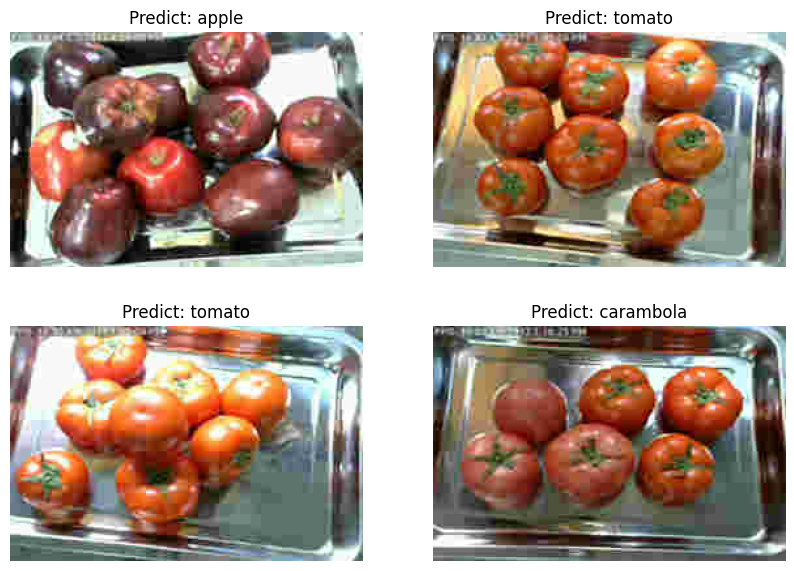

In [46]:
import matplotlib.pyplot as plt
index = [0,110,2229,4193,34,99]
row,column = 2,3
y_pred_ls = np.array([int(i) for i in y_pred_ls])
prob_ls = np.array([float(i) for i in probability_ls])
fig = plt.figure(figsize=(10, 7)) 
for i in range(len(index)):
    fig.add_subplot(row, column, i+1) 
    output_original_image = output_valid_x[i]
    output_original_image = cv2.cvtColor(output_original_image, cv2.COLOR_RGB2BGR)
    plt.imshow(output_original_image) 
    plt.axis('off') 
    class_name = CLASSES[y_pred_ls[index[i]]]
    prob = round(prob_ls[i]*100,2)
    plt.title("Predicted: "+ str(prob)+"% "+class_name) 

In [ ]:
apple_ids = []
for i in range(len(y_pred_ls)):
    if y_pred_ls[i] == 0:
        apple_ids.append(ids[i])
apple_ids = np.array(apple_ids)

def histogram(bins):
    bin_num = int(valid_data_x.shape[0] / bins)
    bin_factor = range(1,bin_num+1)
    bin_ls = np.array([bins]*bin_num) * bin_factor
    plt.hist(apple_ids, bins=bins)  # 'bins' defines the number of intervals or bins
    plt.title('The ID numbers distribution of all apple images in Attachment 3')
    plt.xlabel('ID Number')
    plt.ylabel('Frequency')
    plt.show()
    plt.close()
    
histogram(100)
